# Unit 5 - Financial Planning

In [1]:
# The following is a script to do the following:
# 1. Use the Alternative Free Crypto API and Alpaca API to pull in current crypto pricing and historical stocks & bonds pricing, respectively.
# 2. Calculate the current portfolio value using the pricing data and current amounts of shares, bonds, and crypto. 
# 3. Determine if the amount of money in the portfolio is enough for a sufficient emergency fund.
# 4. Then use the historical pricing data for stocks and bonds to run various Monte Carlo simulations to determine confidence intervals for a portfolio 
#    with a certain initial investment to see if the value is high enough to be able to retire after 5, 10, or 30 years.

In [2]:
#Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import datetime as dt
import json

%matplotlib inline

In [3]:
#Load the .env enviroment variable with API keys
load_dotenv("MY_KEYS.env")

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [4]:
#Set the current amount of crypto assets assumed to be in each union member's portfolio
my_btc = 1.2
my_eth = 5.3

In [5]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/"

In [6]:
# Fetch current BTC price
btc_response_data = requests.get(btc_url).json()

# Fetch current ETH price
eth_response_data = requests.get(eth_url).json()

print(json.dumps([btc_response_data,eth_response_data], indent=4))

[
    {
        "data": {
            "1": {
                "id": 1,
                "name": "Bitcoin",
                "symbol": "BTC",
                "website_slug": "bitcoin",
                "rank": 1,
                "circulating_supply": 18857425,
                "total_supply": 18857425,
                "max_supply": 21000000,
                "quotes": {
                    "USD": {
                        "price": 61741.0,
                        "volume_24h": 53170318789,
                        "market_cap": 1165578979562,
                        "percentage_change_1h": 0.350433051458611,
                        "percentage_change_24h": 4.87634323173073,
                        "percentage_change_7d": -1.27870711470879,
                        "percent_change_1h": 0.350433051458611,
                        "percent_change_24h": 4.87634323173073,
                        "percent_change_7d": -1.27870711470879
                    }
                },
                "last_upda

In [7]:
#Compute the current value of the cryptocurrency holdings
btc_holdings_value = btc_response_data["data"]["1"]["quotes"]["USD"]["price"] * my_btc
eth_holdings_value = eth_response_data["data"]["1027"]["quotes"]["USD"]["price"] * my_eth

#Print the current balance of the cryptocurrency holdings
print(f"The current value of your {my_btc} BTC is ${btc_holdings_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${eth_holdings_value:0.2f}")

The current value of your 1.2 BTC is $74089.20
The current value of your 5.3 ETH is $23251.47


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [8]:
#Set the current amount of shares of stocks and bonds assumed to be in each union member's portfolio
my_agg = 200
my_spy = 50

In [9]:
#Set the Alpaca API key and secret from the .env file
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

#Create the Alpaca API object to communicate the keys
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [10]:
#Set the start date of the data request to "today" using Datetime library which puts it in ISO format
start_date = dt.date.today()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

#Get the current closing prices for SPY and AGG, using a limit of 1000 to get the last 1000 days worth of data
stocks_bonds_df = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    limit=1000,
).df

#Preview the historical price data in the dataframe
stocks_bonds_df.tail()

AGG                                        \
                             open      high      low   close     volume   
time                                                                      
2021-10-22 00:00:00-04:00  113.97  114.1399  113.895  114.07  3309637.0   
2021-10-25 00:00:00-04:00  114.06  114.2700  114.060  114.17  7088133.0   
2021-10-26 00:00:00-04:00  114.25  114.3800  114.110  114.37  5284755.0   
2021-10-27 00:00:00-04:00  114.66  114.9150  114.425  114.77  6817074.0   
2021-10-28 00:00:00-04:00  114.71  114.8250  114.570  114.65  4971007.0   

                              SPY                                      
                             open    high     low   close      volume  
time                                                                   
2021-10-22 00:00:00-04:00  453.13  454.67  451.05  453.13  50771701.0  
2021-10-25 00:00:00-04:00  454.28  455.90  452.39  455.48  37918548.0  
2021-10-26 00:00:00-04:00  457.20  458.49  455.56  455.97  49865704.0  
2021-10-27 00:00:00-04:00  456.45  457.16  453.86  453.92  48219255.0  
2021-10-28 00:00:00-04:00  455.46  458.40  455.45  458.27  43081788.0

In [11]:
#Pull out the current close prices of AGG and SPY
#Since this code may be executed prior to the market opening on a certain day, the code cannot be written using .loc[] using the date "today" because only yesterday's data would be available
#The .loc[] function does not have a simple way to pull out the last row, so here the index is reset to integers so that the .iloc[] function can be used to set the variables for prices, and then the date/time is set as the index once again

spy_close_price = stocks_bonds_df["SPY"]["close"][-1]    
agg_close_price = stocks_bonds_df["AGG"]["close"][-1]   

#Print the current AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $114.65
Current SPY closing price: $458.27


In [12]:
#Compute the current value of the stocks and bonds in the portfolio by using the current close price
my_spy_value = spy_close_price * my_spy
my_agg_value = agg_close_price * my_agg

#Print current value of the stocks and bonds in the portfolio
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $22913.50
The current value of your 200 AGG shares is $22930.00


### Savings Health Analysis

In [13]:
#Set the monthly household income of each credit union member
monthly_income = 12000

#Consolidate the financial assets data into a dictionary
assets = {
    "Crypto" : (btc_holdings_value + eth_holdings_value),
    "Shares" : (my_spy_value + my_agg_value),
}

#Create a savings DataFrame with the combined assets
df_savings = pd.DataFrame(assets, index=["Amount"]).transpose()

#Display the savings DataFrame for viewing
df_savings

,Amount
Crypto,97340.671
Shares,45843.500


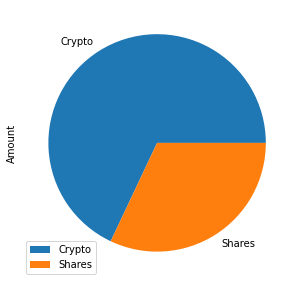

In [14]:
#Plot the savings breakdown in a pie chart
df_savings.plot(kind="pie", y="Amount", figsize = (5,5)).legend(loc="lower left")

In [15]:
#Set the ideal emergency fund equal to 3 months income
emergency_fund = monthly_income * 3

#Calculate current total amount of savings by adding the total current value of crypto and shares
total_savings= df_savings.sum()[0]

#Validate saving health
if total_savings > emergency_fund:
    print("Awesome job! You currently have more than enough money for a proper emergency fund.")
elif total_savings == emergency_fund:
    print("Congratulations on reaching the finanical goal of having a proper emergency fund!")
else:
    print(f"You're currently ${emergency_fund - total_savings:,.2f} away from meeting your emergency fund goal. Keep saving!")

Awesome job! You currently have more than enough money for a proper emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [16]:
#5 years worth of historical data for SPY and AGG from today is desired which equates to 252 * 5 = 1,260 days (approximately) worth of data. 
#Since the limit on the amount of data to pull from Alpaca is only 1000, do two GET requests from Alpace to cover the entire timeframe.
#To do the two GET requests in the next line of data, need to set two end dates to make sure the data is covered, even if there is overlap between the two. Then convert the dates to ISO format. 

MC_end_date1 = dt.date.today()
MC_end_date2 = MC_end_date1.replace(year=MC_end_date1.year - 3)
MC_start_date = MC_end_date1.replace(year=MC_end_date1.year - 5)

converted_end_date1 = pd.Timestamp(MC_end_date1, tz='America/New_York').isoformat()
converted_end_date2 = pd.Timestamp(MC_end_date2, tz='America/New_York').isoformat()
converted_start_date = pd.Timestamp(MC_start_date, tz='America/New_York').isoformat()

In [17]:
#Get the closing prices for SPY and AGG of the last 5 years by doing two GET requests and storing them in two separate dataframes
df_stock_data1 = api.get_barset(
    tickers,
    timeframe,
    start=converted_start_date,
    end=converted_end_date1,
    limit=1000,
).df

df_stock_data2 = api.get_barset(
    tickers,
    timeframe,
    start=converted_start_date,
    end=converted_end_date2,
    limit=1000,
).df

#Send the two dataframes to csv files to be able to review and clean the data (i.e., remove the common overlapping dates from the GET requests)
df_stock_data1.to_csv(path_or_buf='Resources_for_checking/stock_data_1', sep='\t')
df_stock_data2.to_csv(path_or_buf='Resources_for_checking/stock_data_2', sep='\t')

In [18]:
#Remove the common overlapping dates ('2017-11-06' through '2018-10-26') from the noe dataframe and then combine the dataframes by appending them
df_stock_data1.drop(df_stock_data1.index[0:245],axis=0,inplace=True)

df_stock_data = df_stock_data2.append(df_stock_data1)

In [19]:
#Configure the Monte Carlo simulation to forecast 30 years of cumulative returns for the stocks

num_sims = 1000

MC_stocks = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.4,.6],
    num_simulation = num_sims,
    num_trading_days = 252*30
)

In [20]:
#Print the simulation input data
MC_stocks.portfolio_data.head()

AGG                                      \
                             open      high     low    close   volume   
time                                                                    
2016-10-28 00:00:00-04:00  111.11  111.2600  111.08  111.170  1569008   
2016-10-31 00:00:00-04:00  111.30  111.3300  111.21  111.300  2767719   
2016-11-01 00:00:00-04:00  110.88  111.1342  110.82  111.035  4524305   
2016-11-02 00:00:00-04:00  111.12  111.3200  111.06  111.160  2390357   
2016-11-03 00:00:00-04:00  111.03  111.1600  111.01  111.020  2578239   

                                           SPY                          \
                          daily_return    open    high     low   close   
time                                                                     
2016-10-28 00:00:00-04:00          NaN  213.14  213.93  211.71  212.52   
2016-10-31 00:00:00-04:00     0.001169  212.93  213.19  212.36  212.51   
2016-11-01 00:00:00-04:00    -0.002381  212.93  212.99  209.60  211.00   
2016-11-02 00:00:00-04:00     0.001126  210.67  211.10  209.23  209.70   
2016-11-03 00:00:00-04:00    -0.001259  209.99  210.24  208.46  208.84   

                                                   
                              volume daily_return  
time                                               
2016-10-28 00:00:00-04:00  115001746          NaN  
2016-10-31 00:00:00-04:00   47327612    -0.000047  
2016-11-01 00:00:00-04:00   95507331    -0.007106  
2016-11-02 00:00:00-04:00   80583348    -0.006161  
2016-11-03 00:00:00-04:00   70957633    -0.004101

In [21]:
#Run a Monte Carlo simulation to forecast 30 years of cumulative returns for the stocks
MC_stocks.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\bradl\OneDrive\Desktop\FinTech\Homeworks\Personal_Finance_Planner\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000497,1.002838,0.997662,0.995700,0.993675,0.997592,0.992142,1.015722,1.016930,1.010087,...,1.007089,1.009458,1.001782,0.999315,1.001950,0.999136,1.004279,1.005098,0.995828,0.999704
2,1.006809,1.009321,0.988943,0.989813,0.979953,0.997980,0.997651,1.013669,1.019790,1.008009,...,1.008898,1.005486,1.009562,1.004714,0.997171,1.010563,1.002615,0.994983,0.991470,1.002370
3,1.013500,1.007403,1.002364,0.995433,0.984006,0.994540,1.000794,1.016643,1.030780,1.010334,...,1.012988,1.013733,1.009395,1.009485,1.000619,1.008795,1.003516,1.003170,0.983245,1.013043
4,1.010021,1.002001,0.998422,0.992647,0.991552,1.011582,1.006189,1.028552,1.036028,1.009986,...,1.006291,1.024945,0.999877,1.010282,0.984569,1.025406,1.000577,0.995585,0.980609,1.001891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,16.361360,61.495887,8.976415,19.855237,13.910258,15.819712,36.918544,25.067093,51.872238,15.493194,...,14.501761,22.319683,25.069436,11.160236,31.726575,72.886720,21.572659,1.608928,30.118195,23.175300
7557,16.330204,60.876542,9.043729,20.028731,14.178010,15.966249,36.844172,25.249421,51.336367,15.461674,...,14.528019,22.235307,25.015417,11.161732,31.710725,72.303696,21.668010,1.608473,29.950528,23.398177
7558,16.484097,60.632961,9.060726,20.276993,14.087474,15.771482,36.797156,25.138716,50.884915,15.364354,...,14.606484,22.477290,25.164510,11.117749,31.865894,72.475017,21.628736,1.605379,29.737129,23.454088
7559,16.289693,60.979927,9.036198,20.137386,14.039305,15.712030,36.776230,25.051472,50.626172,15.375190,...,14.474417,22.520170,25.079243,11.120487,32.039431,71.831383,21.541744,1.620028,29.814084,23.431621


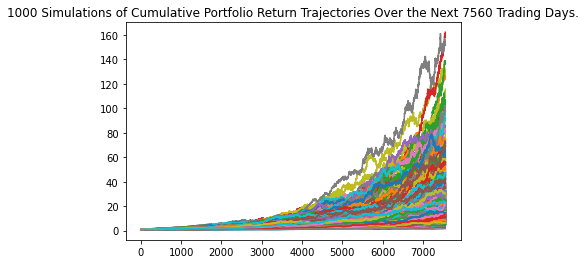

In [22]:
#Plot the Monte Carlo simulation outcomes
MC_stocks_line_plot = MC_stocks.plot_simulation()

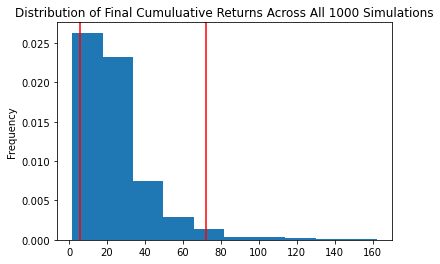

In [23]:
#Plot the probability distribution and confidence intervals for the Monte Carlo simulation of the future stocks' returns
MC_stocks_dist_plot = MC_stocks.plot_distribution()

### Retirement Analysis

In [24]:
#Fetch the summary statistics from the Monte Carlo simulation results and print them
MC_stocks_stats = MC_stocks.summarize_cumulative_return()
print(MC_stocks_stats)

count           1000.000000
mean              24.887253
std               18.534774
min                1.628067
25%               12.724604
50%               20.225849
75%               30.794938
max              162.088652
95% CI Lower       5.797542
95% CI Upper      72.234598
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [25]:
#Set an initial investment to $20,000 to predict portfolio returns
initial_investment = 20000

#Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of the $20,000
returns_ci_lower = round(MC_stocks_stats[8]*initial_investment,2)
returns_ci_upper = round(MC_stocks_stats[9]*initial_investment,2)

#Print the confidence interval results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${returns_ci_lower} and ${returns_ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $115950.84 and $1444691.97


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [26]:
#Increase the initial investment by 50% to predict portfolio returns
initial_investment_increased = int(20000 * 1.5)

#Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of the $30,000
revised_returns_ci_lower = round(MC_stocks_stats[8]*initial_investment_increased,2)
revised_returns_ci_upper = round(MC_stocks_stats[9]*initial_investment_increased,2)

#Print the confidence interval results
print(f"There is a 95% chance that an initial investment of ${initial_investment_increased} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${revised_returns_ci_lower} and ${revised_returns_ci_upper}")

There is a 95% chance that an initial investment of $30000 in the portfolio over the next 30 years will end within in the range of $173926.26 and $2167037.95


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [27]:
#Configure a Monte Carlo simulation to forecast 5 years of cumulative returns for the stocks to explore early retirment options
#The stocks (SPY) to bonds (AGG) ratio was adjusted to 90%/10% since retiring in the shorter 5 year timespan will require the higher returns of stocks compared to bonds.

num_sims = 1000

MC_stocks_5yr = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.1,.9],
    num_simulation = num_sims,
    num_trading_days = 252*5
)

#Print the simulation input data
MC_stocks_5yr.portfolio_data.head()

AGG                                      \
                             open      high     low    close   volume   
time                                                                    
2016-10-28 00:00:00-04:00  111.11  111.2600  111.08  111.170  1569008   
2016-10-31 00:00:00-04:00  111.30  111.3300  111.21  111.300  2767719   
2016-11-01 00:00:00-04:00  110.88  111.1342  110.82  111.035  4524305   
2016-11-02 00:00:00-04:00  111.12  111.3200  111.06  111.160  2390357   
2016-11-03 00:00:00-04:00  111.03  111.1600  111.01  111.020  2578239   

                                           SPY                          \
                          daily_return    open    high     low   close   
time                                                                     
2016-10-28 00:00:00-04:00          NaN  213.14  213.93  211.71  212.52   
2016-10-31 00:00:00-04:00     0.001169  212.93  213.19  212.36  212.51   
2016-11-01 00:00:00-04:00    -0.002381  212.93  212.99  209.60  211.00   
2016-11-02 00:00:00-04:00     0.001126  210.67  211.10  209.23  209.70   
2016-11-03 00:00:00-04:00    -0.001259  209.99  210.24  208.46  208.84   

                                                   
                              volume daily_return  
time                                               
2016-10-28 00:00:00-04:00  115001746          NaN  
2016-10-31 00:00:00-04:00   47327612    -0.000047  
2016-11-01 00:00:00-04:00   95507331    -0.007106  
2016-11-02 00:00:00-04:00   80583348    -0.006161  
2016-11-03 00:00:00-04:00   70957633    -0.004101

In [28]:
#Run a Monte Carlo simulation to forecast 5 years of cumulative returns for the stocks
MC_stocks_5yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\bradl\OneDrive\Desktop\FinTech\Homeworks\Personal_Finance_Planner\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.014908,1.005453,0.995860,0.986889,1.005638,1.012687,1.018820,1.011576,1.008358,1.014563,...,0.990689,0.985655,0.988770,1.024479,0.992718,0.973647,0.990365,0.989557,0.993325,1.010524
2,1.021950,0.986330,1.004231,0.989267,1.002988,1.002593,1.024817,1.022759,1.014564,1.024043,...,0.988653,0.991852,0.974415,1.032029,0.994159,0.949163,0.988193,0.981367,1.000053,1.005163
3,1.020655,0.989441,1.006795,0.980414,1.015683,1.006304,1.035112,1.027766,1.019051,1.024651,...,0.980545,0.976096,0.952408,1.020742,0.979174,0.946933,0.975619,0.973011,0.999325,1.004960
4,1.007611,0.981982,0.989914,0.976087,1.028299,1.009477,1.049817,1.042262,1.036877,1.019089,...,0.990578,0.971344,0.955722,1.028707,0.960081,0.967093,0.981359,0.977190,0.984625,1.007100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.959403,1.314581,1.243195,2.705948,0.838150,2.020536,1.154444,1.468270,2.756636,1.438907,...,1.362750,1.820293,2.491454,2.233171,1.257201,2.254006,2.492878,2.585080,2.407531,1.530839
1257,1.922055,1.319428,1.249586,2.671160,0.835993,1.995934,1.141538,1.458124,2.726130,1.436840,...,1.361011,1.806380,2.498728,2.252256,1.265497,2.206907,2.508280,2.613689,2.388635,1.538411
1258,1.911278,1.327258,1.251483,2.673880,0.827555,1.984244,1.162456,1.462799,2.715712,1.438684,...,1.366938,1.791750,2.496441,2.264234,1.274983,2.194925,2.468113,2.585994,2.427074,1.522764
1259,1.910666,1.305873,1.267037,2.674580,0.821474,1.970461,1.157555,1.456679,2.687460,1.442411,...,1.362674,1.751265,2.492935,2.289963,1.284479,2.212447,2.444196,2.594057,2.472235,1.524548


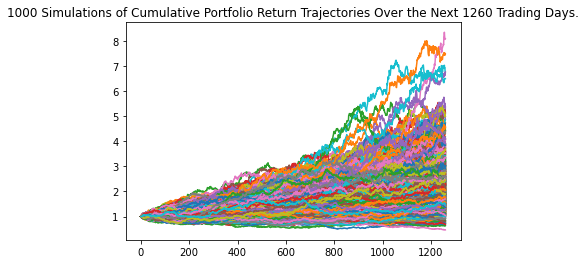

In [29]:
#Plot the Monte Carlo simulation outcomes
MC_stocks_5yr_line_plot = MC_stocks_5yr.plot_simulation()

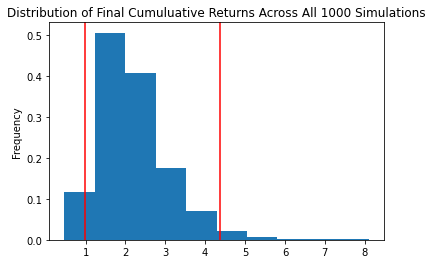

In [30]:
#Plot the probability distribution and confidence intervals for the Monte Carlo simulation of the future stocks' returns
MC_stocks_5yr_dist_plot = MC_stocks_5yr.plot_distribution()

In [31]:
#Fetch the summary statistics from the Monte Carlo simulation results and print them
MC_stocks_5yr_stats = MC_stocks_5yr.summarize_cumulative_return()
print(MC_stocks_5yr_stats)

count           1000.000000
mean               2.203329
std                0.894588
min                0.466119
25%                1.574694
50%                2.046358
75%                2.621706
max                8.100427
95% CI Lower       0.981622
95% CI Upper       4.372204
Name: 1260, dtype: float64


In [32]:
#Set a higher initial investment to $200,000 to predict portfolio returns in the shorter timeframe of 5 years
initial_investment_5yr = 200000

#Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of the $200,000
returns_5yr_ci_lower = round(MC_stocks_5yr_stats[8]*initial_investment_5yr,2)
returns_5yr_ci_upper = round(MC_stocks_5yr_stats[9]*initial_investment_5yr,2)

#Print the confidence interval results
print(f"There is a 95% chance that an initial investment of ${initial_investment_5yr} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${returns_5yr_ci_lower} and ${returns_5yr_ci_upper}")

There is a 95% chance that an initial investment of $200000 in the portfolio over the next 5 years will end within in the range of $196324.34 and $874440.73


**Even with the high 90%/10% allocations of stocks to bonds, at least $200,000 of initial investment is required to get close to being able to retire in 5 years looking at the upper end of the confidence interval. The total amount of money required for retirement is unique to each person though, so the amount of money shown in this simulation may be sufficent for one person and too small for another.**

### Ten Years Retirement Option

In [33]:
#Configure a Monte Carlo simulation to forecast 10 years of cumulative returns for the stocks to explore early retirment options
#The stocks (SPY) to bonds (AGG) ratio was adjusted to 90%/10% since retiring in the shorter 5 year timespan will require the higher returns of stocks compared to bonds.

num_sims = 1000

MC_stocks_10yr = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.1,.9],
    num_simulation = num_sims,
    num_trading_days = 252*10
)

#Print the simulation input data
MC_stocks_10yr.portfolio_data.head()

AGG                                      \
                             open      high     low    close   volume   
time                                                                    
2016-10-28 00:00:00-04:00  111.11  111.2600  111.08  111.170  1569008   
2016-10-31 00:00:00-04:00  111.30  111.3300  111.21  111.300  2767719   
2016-11-01 00:00:00-04:00  110.88  111.1342  110.82  111.035  4524305   
2016-11-02 00:00:00-04:00  111.12  111.3200  111.06  111.160  2390357   
2016-11-03 00:00:00-04:00  111.03  111.1600  111.01  111.020  2578239   

                                           SPY                          \
                          daily_return    open    high     low   close   
time                                                                     
2016-10-28 00:00:00-04:00          NaN  213.14  213.93  211.71  212.52   
2016-10-31 00:00:00-04:00     0.001169  212.93  213.19  212.36  212.51   
2016-11-01 00:00:00-04:00    -0.002381  212.93  212.99  209.60  211.00   
2016-11-02 00:00:00-04:00     0.001126  210.67  211.10  209.23  209.70   
2016-11-03 00:00:00-04:00    -0.001259  209.99  210.24  208.46  208.84   

                                                   
                              volume daily_return  
time                                               
2016-10-28 00:00:00-04:00  115001746          NaN  
2016-10-31 00:00:00-04:00   47327612    -0.000047  
2016-11-01 00:00:00-04:00   95507331    -0.007106  
2016-11-02 00:00:00-04:00   80583348    -0.006161  
2016-11-03 00:00:00-04:00   70957633    -0.004101

In [34]:
#Run a Monte Carlo simulation to forecast 10 years of cumulative returns for the stocks
MC_stocks_10yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\bradl\OneDrive\Desktop\FinTech\Homeworks\Personal_Finance_Planner\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000128,0.997155,0.991902,0.993934,1.008205,0.995389,0.991506,1.011325,1.005999,0.991222,...,0.983561,1.013966,1.004609,1.006374,1.011529,0.999530,1.003831,0.994315,0.984333,0.974392
2,0.982584,1.013627,0.982612,0.994908,1.013732,0.992308,0.995126,1.024221,1.003650,0.997381,...,0.995829,1.021989,1.009144,1.001872,1.039681,1.003137,0.998840,1.002424,0.990163,0.967023
3,0.985036,1.001236,0.975711,0.998799,1.007359,0.993873,1.000588,1.011876,0.992859,0.990927,...,0.987728,1.022568,1.009364,0.992546,1.034356,0.997010,1.003095,1.001380,0.994421,0.951225
4,1.005083,0.995498,0.983841,1.004035,1.011359,0.992343,0.988594,1.023764,0.990510,0.990578,...,0.990268,1.011891,1.005680,0.963814,1.023217,0.994549,1.011206,0.990409,0.992625,0.939313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,3.498579,5.310083,2.585506,1.993658,3.321719,8.262833,3.036572,2.432461,4.897246,2.390630,...,5.609862,3.093188,1.847661,1.860764,2.451167,4.387708,4.827551,8.883625,2.291610,2.408271
2517,3.554538,5.342694,2.593310,1.960777,3.350748,8.293999,3.081057,2.446978,4.989904,2.381363,...,5.624650,3.081847,1.863340,1.838662,2.457721,4.419413,4.761316,8.808659,2.342953,2.420371
2518,3.584857,5.325653,2.602450,1.979611,3.410051,8.257631,3.161265,2.397641,4.958196,2.380020,...,5.727877,3.104935,1.887156,1.852986,2.436197,4.435490,4.661311,8.849618,2.360923,2.446178
2519,3.594949,5.309635,2.626169,1.971042,3.447222,8.138916,3.168004,2.367322,4.921570,2.434572,...,5.846738,3.144951,1.894340,1.837825,2.444933,4.468657,4.604773,8.841836,2.341198,2.439484


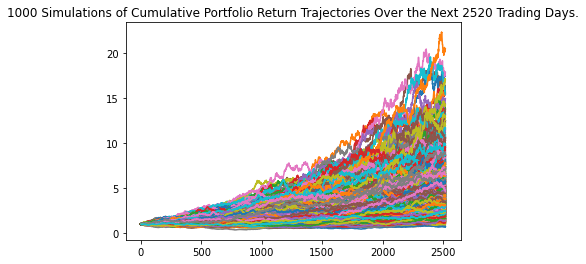

In [35]:
#Plot the Monte Carlo simulation outcomes
MC_stocks_10yr_line_plot = MC_stocks_10yr.plot_simulation()

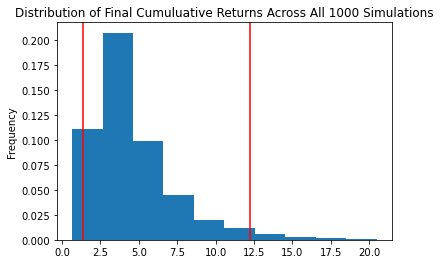

In [36]:
#Plot the probability distribution and confidence intervals for the Monte Carlo simulation of the future stocks' returns
MC_stocks_10yr_dist_plot = MC_stocks_10yr.plot_distribution()

In [37]:
#Fetch the summary statistics from the Monte Carlo simulation results and print them
MC_stocks_10yr_stats = MC_stocks_10yr.summarize_cumulative_return()
print(MC_stocks_10yr_stats)

count           1000.000000
mean               4.583395
std                2.733057
min                0.661922
25%                2.781434
50%                3.818823
75%                5.662997
max               20.477383
95% CI Lower       1.362696
95% CI Upper      12.249053
Name: 2520, dtype: float64


In [38]:
#Set a higher initial investment to $50,000 to predict portfolio returns in the shorter timeframe of 10 years
initial_investment_10yr = 100000

#Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of the $100,000
returns_10yr_ci_lower = round(MC_stocks_10yr_stats[8]*initial_investment_10yr,2)
returns_10yr_ci_upper = round(MC_stocks_10yr_stats[9]*initial_investment_10yr,2)

#Print the confidence interval results
print(f"There is a 95% chance that an initial investment of ${initial_investment_10yr} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${returns_10yr_ci_lower} and ${returns_10yr_ci_upper}")

There is a 95% chance that an initial investment of $100000 in the portfolio over the next 10 years will end within in the range of $136269.63 and $1224905.3


**Unlike in the 5 year similuation, the high 90%/10% allocations of stocks to bonds for the 10 year timeframe gets us closer to an amount of money that is sufficient for retirement. This simulation also used only 100,000 of initial investment, which is more feasible than the 200,000 used for the 5 year timeframe; however, it is still 5x the initial investment used for the 30 year retirement timeframe (i.e, $20,000). Again though, the total amount of money required for retirement is unique to each person though, so the amount of money shown in this simulation may be sufficent for one person and too small for another.**